In [8]:
import sys
import pandas as pd
import numpy as np
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.evaluation.python_evaluation import (
    map_at_k,
    ndcg_at_k,
    precision_at_k,
    recall_at_k,
    rmse,
    mae,
    logloss,
    rsquared,
    exp_var,
    auc,
    confusion_matrix
)
from recommenders.utils.timer import Timer
from sklearn.preprocessing import minmax_scale
from recommenders.utils.python_utils import binarize

In [78]:
def load_df(size="1"):
  if(size==5):
    df = pd.read_csv(f"./drive/MyDrive/netflix dataset/combined_data_1.txt",header = None, names = ['userID', 'rating','timestamp'], usecols = [0,1,2])
    for i in range(2,5):
      df_temp = pd.read_csv(f"./drive/MyDrive/netflix dataset/combined_data_{i}.txt",header = None, names = ['userID', 'rating','timestamp'], usecols = [0,1,2])
      df.append(df_temp)
  else:
    df = pd.read_csv(f"./drive/MyDrive/netflix dataset/combined_data_{size}.txt",header = None, names = ['userID', 'rating','timestamp'], usecols = [0,1,2])
  df.index = np.arange(0,len(df))
  df_nan = pd.DataFrame(pd.isnull(df.rating))
  df_nan = df_nan[df_nan['rating'] == True]
  df_nan = df_nan.reset_index()
  movie_np = []
  movie_id = 1
  for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
      temp = np.full((1,i-j-1), movie_id)
      movie_np = np.append(movie_np, temp)
      movie_id += 1
  last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
  movie_np = np.append(movie_np, last_record)
  df = df[pd.notnull(df['rating'])]
  df['itemID'] = movie_np.astype(int)
  df['userID'] = df['userID'].astype(int)
  df['rating'] = df['rating'].astype(float)
  df = df[df["itemID"]<=1500]
  df = df[df["userID"]<=50000]
  return df

In [79]:
df = load_df()

In [80]:
train, test = python_chrono_split(df, 0.80)

In [5]:
test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]

In [6]:
train_file = "./drive/MyDrive/train.csv"
test_file = "./drive/MyDrive/test.csv"
train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)

In [7]:
data = NCFDataset(train_file=train_file, test_file=test_file, seed=42)

INFO:recommenders.models.ncf.dataset:Indexing ./drive/MyDrive/train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ./drive/MyDrive/test.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ./drive/MyDrive/test_full.csv ...


In [8]:
data.n_users,data.n_items

(8169, 1374)

In [9]:
model = NCF(
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=[16,8,4],
    n_epochs=30,
    batch_size=256,
    learning_rate=1e-3,
    verbose=5,
    seed=42
)

C:\Users\ankit\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [10]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time))

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 5 [64.71s]: train_loss = 0.205893 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [64.37s]: train_loss = 0.186696 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 15 [64.85s]: train_loss = 0.178566 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [64.77s]: train_loss = 0.172203 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 25 [29.61s]: train_loss = 0.168211 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [30.40s]: train_loss = 0.164668 


Took 1723.4384 seconds for training.


In [11]:
with Timer() as test_time:
    users, items, preds = [], [], []
    item = list(train.itemID.unique())
    for user in train.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time))

Took 89.3963 seconds for prediction.


In [12]:
from recommenders.evaluation.python_evaluation import (map_at_k, ndcg_at_k, precision_at_k,recall_at_k)

In [13]:
eval_map = map_at_k(test, all_predictions, col_user='userID', col_item='itemID', col_rating='rating', k=10)
eval_ndcg = ndcg_at_k(test, all_predictions, col_user='userID', col_item='itemID', col_rating='rating', k=10)
eval_precision = precision_at_k(test, all_predictions, col_user='userID', col_item='itemID', col_rating='rating', k=10)
eval_recall = recall_at_k(test, all_predictions, col_user='userID', col_item='itemID', col_rating='rating', k=10)
eval_rmse = rmse(test, all_predictions, col_user='userID', col_item='itemID', col_rating='rating')
eval_mae = mae(test, all_predictions, col_user='userID', col_item='itemID', col_rating='rating')
eval_rsquared = rsquared(test, all_predictions, col_user='userID', col_item='itemID', col_rating='rating')
eval_exp_var = exp_var(test, all_predictions, col_user='userID', col_item='itemID', col_rating='rating')
# eval_auc = auc(test, all_predictions, col_user='userID', col_item='itemID', col_rating='rating')

positivity_threshold = 2
test_bin = test.copy()
test_bin['rating'] = binarize(test_bin['rating'], positivity_threshold)

top_k_prob = all_predictions.copy()
top_k_prob['prediction'] = minmax_scale(
    top_k_prob['prediction'].astype(float)
)

eval_logloss = logloss(test_bin, top_k_prob, col_user='userID', col_item='itemID', col_rating='rating')

print("Model:\t",
      "Top K:\t%d" % 10,
      "MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall,
      "RMSE:\t%f" %eval_rmse,
      "MAE:\t%f" %eval_mae,
      "RSquared:\t%f" %eval_rsquared,
      "Exp_Var:\t%f" %eval_exp_var,
      "Logloss:\t%f" % eval_logloss,
      sep='\n')

Model:	
Top K:	10
MAP:	0.086539
NDCG:	0.154337
Precision@K:	0.073635
Recall@K:	0.222977
RMSE:	3.327009
MAE:	3.147441
RSquared:	-8.989719
Exp_Var:	-0.049246
Logloss:	1.448773


In [14]:
from tqdm import tqdm

In [71]:
def score(test):
    users, items, preds = [], [], []
    item = list(test.itemID.unique())
    for user in test.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))
    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})
    preds = all_predictions.pivot_table(index=["userID"], columns=["itemID"], values="prediction")
    return preds.to_numpy()

In [11]:
conf_mat = confusion_matrix(model,test,"NCF")

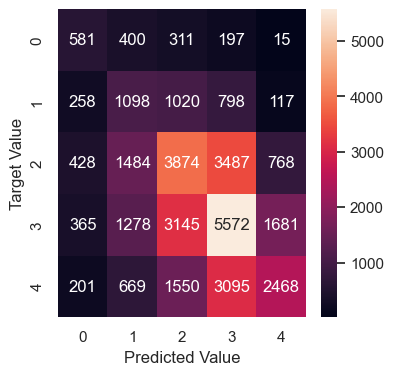

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(4,4)})
sns.heatmap(conf_mat,fmt='',annot=True)
plt.xlabel("Predicted Value")
plt.ylabel("Target Value")
plt.show()